In [41]:
%reload_ext autoreload
%autoreload 2

import projcore as pc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

In [20]:
pc.download_kaggle_datasets()
battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')


File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


In [21]:
battles_df = pc.feature_preprocessing(battles_df, winning_card_list_df)

In [11]:
battles_df.head(100).to_csv("battles_subset.csv", index=False)


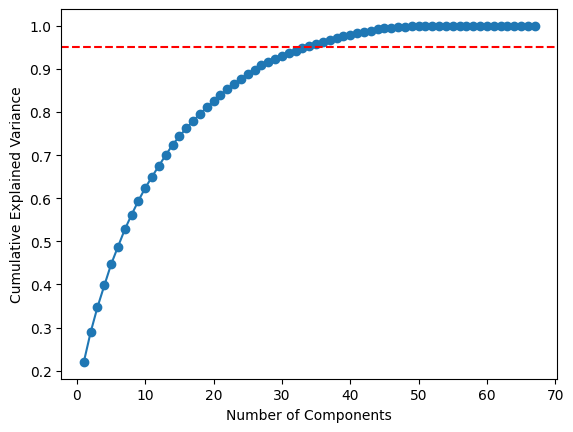

Best component: 34 with a cumulative_variance value of: 0.9537
Explained Variance Ratio: 0.9537495798660082


In [22]:
filtered_df, n = pc.get_pca_optimal_components(battles_df)  
pca_n = PCA(n_components=n)
pca_for_df = pca_n.fit_transform(filtered_df)
df_pca = pd.DataFrame(pca_for_df, columns=[f"PC{i+1}" for i in range(n)])

print("Explained Variance Ratio:", pca_n.explained_variance_ratio_.sum())

In [17]:
winner = [f'winner.card{i}.id' for i in range(1, 9)]
loser = [f'loser.card{i}.id' for i in range(1, 9)]
#battles_df["winner.card_set"] = battles_df.apply(lambda row: tuple(sorted([row[f"winner.card{i}.id"] for i in range(1, 9)])), axis=1)
unique = battles_df["winner.card_set"].value_counts().reset_index()
print(len(unique))
print(unique.head())

1292041
                                               index  winner.card_set
0  (26000000, 26000026, 26000030, 26000041, 27000...            38417
1  (26000010, 26000014, 26000021, 26000030, 26000...            32739
2  (26000004, 26000036, 26000042, 26000046, 26000...            25585
3  (26000000, 26000001, 26000010, 26000030, 27000...            15276
4  (26000009, 26000015, 26000035, 26000039, 26000...            11148


In [ ]:

from sklearn.manifold import TSNE, MDS
from scipy.spatial.distance import pdist, squareform
import ast
import random
import seaborn as sns

unique_decks = battles_df["winner.card_set"].unique()
deck_wins = battles_df.groupby("winner.card_set").size()
deck_losses = battles_df.groupby("loser.card_set").size()
deck_total_games = deck_wins.add(deck_losses, fill_value=0)
deck_win_rate = (deck_wins / deck_total_games).fillna(0)  # Win rate as fraction
win_rate_dict = deck_win_rate.to_dict()



KeyboardInterrupt: 

In [34]:
# Process decks in batches
batch_size = 1000
num_batches = len(unique_decks) // batch_size + 1

mds_results = []
tsne_results = []

for batch in range(num_batches):
    if batch + 1 % 10 == 0:
        print(f"Processing batch {batch + 1}/{num_batches}")
    start = batch * batch_size
    end = min((batch + 1) * batch_size, len(unique_decks))
    batch_decks = unique_decks[start:end]

    if len(batch_decks) < 2:
        continue  # Skip empty batches

    # Compute pairwise Hamming distance for this batch
    def deck_distance(deck1, deck2):
        return len(set(deck1).symmetric_difference(set(deck2)))

    distance_matrix = squareform(pdist(list(batch_decks), metric=lambda u, v: deck_distance(u, v)))

    # Apply MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_positions = mds.fit_transform(distance_matrix)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate=200, n_iter=1000, metric="precomputed", init="random")
    tsne_positions = tsne.fit_transform(distance_matrix)

    # Store batch results
    for i, deck in enumerate(batch_decks):
        win_rate = win_rate_dict.get(deck, 0)  # Default 0 if no win rate data
        mds_results.append([mds_positions[i, 0], mds_positions[i, 1], win_rate])
        tsne_results.append([tsne_positions[i, 0], tsne_positions[i, 1], win_rate])

# Convert results to DataFrame
mds_df = pd.DataFrame(mds_results, columns=["X", "Y", "WinRate"])
tsne_df = pd.DataFrame(tsne_results, columns=["X", "Y", "WinRate"])

# Plot MDS & t-SNE with Win Rate Mapping
plt.figure(figsize=(12, 6))

# MDS Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x="X", y="Y", hue="WinRate", palette="viridis", data=mds_df, alpha=0.7)
plt.colorbar()
plt.title("Deck Similarity using MDS (Win Rate Overlay)")

# t-SNE Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x="X", y="Y", hue="WinRate", palette="viridis", data=tsne_df, alpha=0.7)
plt.colorbar()
plt.title("Deck Similarity using t-SNE (Win Rate Overlay)")

# Save Figures
plt.savefig("deck_similarity_mds_winrate.png", dpi=300)
plt.savefig("deck_similarity_tsne_winrate.png", dpi=300)

plt.show()


Processing batch 1/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 2/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 3/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 4/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 5/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 6/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 7/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 8/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 9/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 10/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 11/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 12/1293


/Users/roni/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing batch 13/1293


KeyboardInterrupt: 